Dưới đây là những class và function mà bọn em code để xử lý bài toán.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import f,t
import math
from statsmodels.stats.stattools import durbin_watson as dw
import warnings
warnings.filterwarnings('ignore')

class Linear_Model():
  def __init__(self, X, y):
    def coefficients(X, y):
      XTX_inv = np.linalg.inv(X.T @ X)
      XTy     = X.T @ y
      beta    = XTX_inv @ XTy
      return beta
    self.beta= coefficients(X, y)
    def summary(X, y):
      y_pred = self.predict(X)
      MSE = np.sum(np.square(y_pred - y))

      variance = MSE * (np.linalg.inv(X.T @ X).diagonal())  / (X.shape[0] -X.shape[1])

      standard_error = np.sqrt(variance)

      t_statistic = self.beta / standard_error

      p_values = 2*(1 - t.cdf(X.shape[0], np.abs(t_statistic)))

      results = pd.DataFrame({'feature': X.columns,
                              'coefficients': self.beta,
                              'standard_error': standard_error,
                              't-statistic': t_statistic,
                              'P>|t|': p_values})
      t_alpha = t.ppf(1-(0.05/(2*(X.shape[1]))),(X.shape[0]-X.shape[1]))
      results['[0.025'] = results['coefficients'] - results['standard_error']*np.sqrt(t_alpha*(X.shape[1]))
      results['0.975]'] = results['coefficients'] + results['standard_error']*np.sqrt(t_alpha*(X.shape[1]))
      results.set_index('feature')
      RSS = np.sum(np.square(y_pred - y))
      TSS = np.sum(np.square(y - np.mean(y)))
      r_squared = 1 -RSS/TSS
      f_stat = (TSS-RSS)/X.shape[1]*(X.shape[0] - X.shape[1] - 1)/RSS
      return results, r_squared, f_stat
    self.summary, self.r_squared, self.f_stat = summary(X,y)
    self.eps_hat = self.predict(X) - y
  def predict(self, X):
    return X @ self.beta
  def f_test(self):
    return bool(self.f_stat > f.ppf(q=1-.01, dfn=X.shape[1], dfd=X.shape[0]-X.shape[1]))
  def t_test(self):
    I_H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T
    for i in range(len(I_H)):
      I_H[i][i] -= 1
    I_H = -1*I_H
    Lambda, P = np.linalg.eig(I_H)
    for i in range(len(Lambda)):
      Lambda[i] = round(Lambda[i].real)
      for j in range(len(P[0])):
        P[i][j] = P[i][j].real
    Lambda = np.array(Lambda, dtype='int64')
    P = np.array(P, dtype='float64')
    i = 0
    j = len(Lambda)-1
    while i <= j:
      while Lambda[i] != 0:
        i += 1
      while Lambda[j] != 1:
        j -= 1
      if i <= j:
        Lambda[i], Lambda[j] = Lambda[j], Lambda[i]
        P[i], P[j] = P[j], P[i]
        i += 1
        j -= 1
    eps_star = P.T @ self.eps_hat
    eps_star_hat = np.sum(eps_star/(len(Lambda)-len(self.beta)-1))
    t_const = np.sqrt((len(Lambda)-len(self.beta)-1))*eps_star_hat
    t_const = t_const/np.sqrt((np.sum((eps_star-eps_star_hat)**2))/(len(Lambda)-len(self.beta)-2))
    return t_const > t.ppf(1-0.025, (len(Lambda)-len(self.beta)-2))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## I. Dữ liệu Advertising

### Mô tả

Tập dữ liệu bao gồm doanh số ở 200 thị trường khác nhau, cùng với ngân sách quảng cáo ở mỗi thị trường đó trên 3 phương tiện truyền thông: 

 - **TV**: Ngân sách dùng để quảng cáo trên TV.
 - **Radio**: Ngân sách dùng để quảng cáo trên Radio.
 - **Newspaper**: Ngân sách dùng để quảng cáo trên Báo.
 - **Sales**: Doanh số thu được. 

**Sales** là biến Response. Chúng ta sẽ xây dựng mô hình dự đoán **Sales** dựa trên ngân sách đầu tư cho quảng cáo bằng cách trả lời các câu hỏi:

0.   Có sự cộng tuyến giữa **TV**, **Radio**, **Newspaper** không?
1.   Có mối liên hệ nào giữa doanh số và ngân sách quảng cáo hay không?
2.   Mối liên hệ này chặt chẽ cỡ nào?
3.   Kênh quảng cáo nào đóng góp vào doanh số?
4.   Liệu có ảnh hưởng cộng năng giữa các kênh quảng cáo hay không?






In [ ]:
data = pd.read_csv("/content/Advertising.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


#0. Có sự cộng tuyến giữa **TV**, **Radio**, **Newspaper** không?*

In [ ]:
data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


#1. Có mối liên hệ nào giữa doanh số và ngân sách quảng cáo hay không?


*   Xây dựng mô hình hồi quy tuyến tính đa biến sử dụng cả 3 biến **TV**, **Radio**, **Newspaper** để dự đoán **Sales**
*   Sử dụng tiêu chuẩn *F* để kiểm tra mối liên hệ giữa **TV**, **Radio**, **Newspaper** và **Sales**



In [ ]:
X = data[['TV', 'Radio', 'Newspaper']]
X = sm.add_constant(X) 
y = data['Sales']

In [ ]:
model = Linear_Model(X, y)

In [ ]:
model.summary

,feature,coefficients,standard_error,t-statistic,P>|t|,[0.025,0.975]
0,const,2.938889,0.311908,9.422288,0.000000,1.948421,3.929358
1,TV,0.045765,0.001395,32.808624,0.000000,0.041335,0.050194
2,Radio,0.188530,0.008611,21.893496,0.000000,0.161185,0.215875
3,Newspaper,-0.001037,0.005871,-0.176715,0.301033,-0.019681,0.017606


In [ ]:
print("Chỉ số F_statistic: ",model.f_stat) 

Chỉ số F_statistic:  425.52086943950275


In [ ]:
print("Kiểm định F:", model.f_test()) #True tuc la beta khac 0

Kiểm định F: True


Như vậy, tồn tại mối liên hệ nào giữa doanh số và ngân sách quảng cáo.

#2. Mối liên hệ này chặt chẽ cỡ nào?


*   Sử dụng hệ số xác định *R* để kiểm tra

In [ ]:
model.r_squared

0.8972106381789522

Hệ số xác định R = 0.897 là con số khá cao, chứng tỏ mối liên hệ này khá chặt chẽ

#3. Kênh quảng cáo nào đóng góp vào doanh số?


*   Sử dụng phương pháp ***stepwise*** để lựa chọn những kênh quảng cáo đóng góp vào doanh số.

In [ ]:
X1 = data[['TV', 'Radio', 'Newspaper']]
X1 = sm.add_constant(X1) 
y = data['Sales']
model1 = Linear_Model(X1, y)
model1.summary

,feature,coefficients,standard_error,t-statistic,P>|t|,[0.025,0.975]
0,const,2.938889,0.311908,9.422288,0.000000,1.948421,3.929358
1,TV,0.045765,0.001395,32.808624,0.000000,0.041335,0.050194
2,Radio,0.188530,0.008611,21.893496,0.000000,0.161185,0.215875
3,Newspaper,-0.001037,0.005871,-0.176715,0.301033,-0.019681,0.017606


In [ ]:
model1.r_squared

0.8972106381789522

Vì p-value của Newspaper rất lớn nên ta sẽ loại Newspaper ra khỏi mô hình, vì vậy chỉ có **TV** và **Radio** có đóng góp vào doanh số.

#4. Liệu có ảnh hưởng cộng năng giữa các kênh quảng cáo hay không?


*   Như ta đã thấy chỉ có biến **TV** và **Radio** có mối liên hệ giữa với **Sales**.
*   Ta sẽ xây dựng biến thứ 3 bằng cách lấy **TVxRadio** để thể hiện sự công năng của 2 kênh này.

In [ ]:
X = data[['TV', 'Radio']]
X['TVxRadio'] = X['TV']*X['Radio']
X = sm.add_constant(X)
y = data['Sales']
model = Linear_Model(X,y)
model.summary

,feature,coefficients,standard_error,t-statistic,P>|t|,[0.025,0.975]
0,const,6.750220,0.247871,27.232755,0.000000e+00,5.963102,7.537339
1,TV,0.019101,0.001504,12.698953,0.000000e+00,0.014325,0.023878
2,Radio,0.028860,0.008905,3.240815,9.633934e-08,0.000582,0.057139
3,TVxRadio,0.001086,0.000052,20.726564,0.000000e+00,0.000920,0.001253


In [ ]:
model.r_squared

0.9677905498482523

Ta có thể thấy, độ chính xác của mô hình đã tăng lên đáng kể, từ 0.897 lên 0.968. Vì vậy, có sự cộng năng giữa **TV** và **Radio**, tức là 2 kênh quảng cáo này bổ trợ cho nhau giúp truyền thông tốt hơn.

## II. Kiểm tra sự phù hợp của mô hình


1.   Tiêu chuẩn ***Student***.
2.   Khảo sát đồ thị phần dư + xác định các ***Outlier***.
3.   Kiểm định tính không tương quan của phần dư theo thời gian.
4.   Xác định các điểm ***Leverage***


#1. Tiêu chuẩn ***Student***




In [ ]:
model.t_test() #False tuc la khong the bac bo phan du tuan theo phan phoi chuan

False

Vậy ta không thể bác bỏ phần dư tuân theo phân phối chuẩn.

#2.   Khảo sát đồ thị phần dư + xác định các ***Outlier***.
* Ta sẽ sử dụng công thức Standardlized để chuẩn hóa phàn dư của tất cả các quan sát thành thành mẫu có trung bình là 0 và độ lệch chuẩn là 1. Sau đó loại bỏ những quan sát có trị tuyệt đối phần dư được chuẩn hóa > 3

In [ ]:
y_pred = model.predict(X)
residuals = np.array(y - y_pred)
# Estimate variance (externalised)
σi_est = []
for i in range(X.shape[0]):
    # exclude ith observation from estimation of variance
    external_residuals = np.delete(residuals, i)
    σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1])) * np.sum(np.square(external_residuals)))]
σi_est = np.array(σi_est)
t_stat = residuals / σi_est

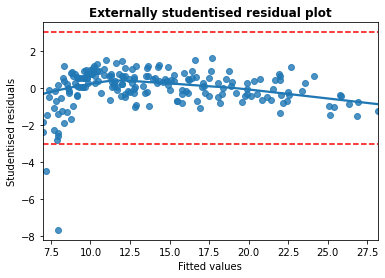

In [ ]:
ax = sns.regplot(x=y_pred, y=t_stat, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Studentised residuals')
plt.title('Externally studentised residual plot', fontweight='bold')
ax.axhline(y=3, color='r', linestyle='dashed')
ax.axhline(y=-3, color='r', linestyle='dashed')

Ta có thể thấy dữ liệu của chúng ta có 2 điểm Outlier. Chúng ta sẽ  lưu 2 điểm này vào drop_list để sau này *xóa* 2 điểm này khỏi dữ liệu.

In [ ]:
drop_list = []
for i in range(len(t_stat)-1):
  if abs(t_stat[i]) > 3:
    drop_list.append(i)

#3.   Kiểm định tính không tương quan của phần dư theo thời gian.

In [ ]:
DW = dw(residuals)
print(DW)

2.2236287420696197


*  Ta có d1(3, 200, 0.05)= 1.738, d2(3, 200, 0.05)= 1.799
*  Vì DW = 2.224 nên DW thuộc khoảng (4-d2, 4-d1) = (2.201, 2.262) nên không thể kết luận được

#4. Xác định các điểm ***Leverage***



*   Vì trung bình leverage của tất cả các quan sát là (p+1)/n với p là số biến dự đoán, n là số lượng quan sát. Ta sẽ sử dụng công thức Standardlized để chuẩn hóa Leverage của tất cả các quan sát thành thành mẫu có trung bình là 0 và độ lệch chuẩn là 1. Sau đó loại bỏ những quan sát có trị tuyệt đối Leverage được chuẩn hóa > 2.75



In [ ]:
#leverage
H = np.array(np.array(X @ np.linalg.inv(X.T @ X)) @ X.T)
h_ii = H.diagonal()
lσi_est = []
for i in range(X.shape[0]):
    # exclude ith observation from estimation of variance
    external_leverage = np.delete(h_ii, i)
    lσi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1])) * np.sum(np.square(external_leverage)))]
lσi_est = np.array(lσi_est)

# Externally studentised leverage
student_leverage = (h_ii-X.shape[1]/X.shape[0]) / lσi_est * np.sqrt(1 - h_ii)

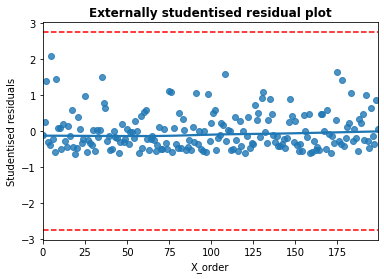

In [ ]:
ax = sns.regplot(x=np.arange(200), y=student_leverage, lowess=True)
plt.xlabel('X_order')
plt.ylabel('Studentised residuals')
plt.title('Externally studentised residual plot', fontweight='bold')
ax.axhline(y=2.75, color='r', linestyle='dashed')
ax.axhline(y=-2.75, color='r', linestyle='dashed')

* Ta có thể thấy dữ liệu không có điểm nào là điểm Leverage. Ta sẽ xóa 2 outlier nằm trong drop_lít

In [ ]:
X.drop(drop_list, inplace=True)
y.drop(drop_list, inplace=True)

(198, 4)

#III. Xây dựng mô hình cuối cùng


1.   Ước lượng hệ số hồi quy và khoảng tin cậy của chúng.
2.   Xác định hệ số R
3.   Ước lượng hàm HQTT



#1.   Ước lượng hệ số hồi quy và khoảng tin cậy của chúng.

In [ ]:
model = Linear_Model(X,y)
model.summary

,feature,coefficients,standard_error,t-statistic,P>|t|,[0.025,0.975]
0,const,6.840642,0.206104,33.190318,0.000000e+00,6.186126,7.495157
1,TV,0.018597,0.001246,14.928898,0.000000e+00,0.014641,0.022552
2,Radio,0.034022,0.007422,4.583877,3.432350e-10,0.010452,0.057591
3,TVxRadio,0.001063,0.000043,24.445089,0.000000e+00,0.000925,0.001201


#2.   Xác định hệ số R

In [ ]:
model.r_squared

0.9774918671223143

#3.   Ước lượng hàm HQTT

In [ ]:
#Ước lượng HQTT
interval = []
y_pred = model.predict(X)
XT_X_inv = np.linalg.inv(X.T @ X)
sigma_hat = np.sum(np.square(y_pred-y))/(X.shape[0]-X.shape[1])
for i in range(len(X)):
  X0 = np.array(X.values[i])
  interval.append(t.ppf(1-0.025, (X.shape[0]-X.shape[1]))* np.sqrt(sigma_hat*(np.array(X0 @ XT_X_inv) @ X0)))
predict_interval = pd.DataFrame()
predict_interval['predict'] = y_pred
predict_interval['[0.025'] = y_pred - interval
predict_interval['0.975]'] = y_pred + interval
predict_interval

,predict,[0.025,0.975]
0,21.650619,21.449677,21.851560
1,10.864092,10.611038,11.117145
2,9.561230,9.198725,9.923735
3,17.713639,17.542887,17.884392
4,12.645797,12.490294,12.801299
...,...,...,...
195,7.827140,7.534923,8.119357
196,9.249756,9.048570,9.450942
197,12.198275,12.037475,12.359075
198,26.203979,25.892829,26.515129
